Downloaded Data Files

# Get Google Drive Ready

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dir_data = "/content/drive/MyDrive/datasetpng"
dir_seg = dir_data + "/annotations_prepped_train/*.png"
dir_img = dir_data + "/images_prepped_train/"

### Display 3 images and their associated 5 segmentation classes

In this NOAA GOES-R data set, there are 5 segmentation classes, showing the difference between radiance channels 15 and 13

seg.shape=(224, 224, 3), img_is.shape=(224, 224, 3)
min seg = 0, max seg = 4, total number of segmentation classes = 5


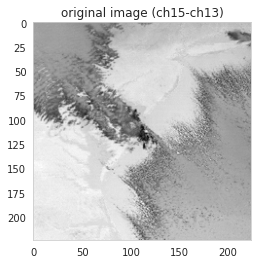

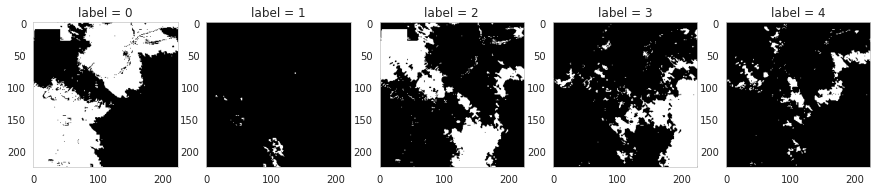

seg.shape=(224, 224, 3), img_is.shape=(224, 224, 3)
min seg = 0, max seg = 4, total number of segmentation classes = 5


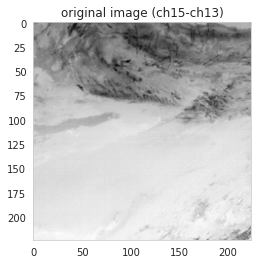

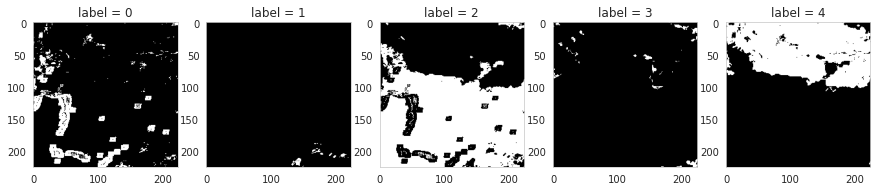

seg.shape=(224, 224, 3), img_is.shape=(224, 224, 3)
min seg = 0, max seg = 4, total number of segmentation classes = 5


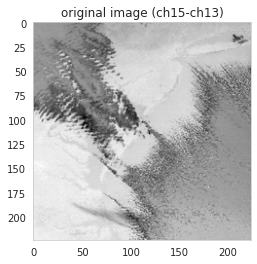

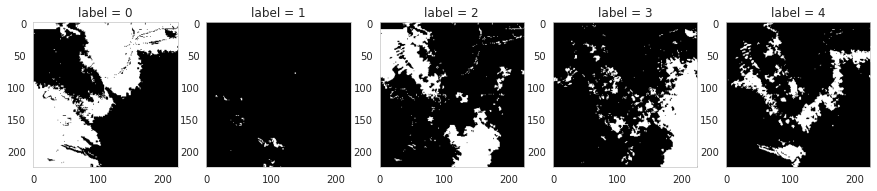

In [3]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

# pickout three random files from list
filenamelist = random.sample(sorted(glob.glob(dir_seg)), 3)

for filen in filenamelist:
    # this search string start/end are different from laptop
    # on my laptop, the value is [53:69] -- don't overwrite (rcd, 26 Feb 21) 
    searchstr = filen[60:76]
    # print(searchstr)
 
    # seaborn has white grid by default -- don't use
    sns.set_style("whitegrid", {'axes.grid' : False})

    # read in the original image and segmentation labels
    seg = cv2.imread(filen)
    img_is = cv2.imread(dir_img+searchstr+'i.png')
    print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))
 
    # Check the number of labels
    # mi, ma is the start and end of the classes
    mi, ma = 0, 4
    n_classes = ma - mi + 1
    print("min seg = {}, max seg = {}, total number of segmentation classes = {}".format(mi,ma, n_classes))
 
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img_is)
    ax.set_title("original image (ch15-ch13)")
    plt.show()
 
    fig = plt.figure(figsize=(15,10))
    for k in range(mi,ma+1):
        ax = fig.add_subplot(1,n_classes,k+1)
        ax.imshow((seg == k)*1.0)
        ax.set_title("label = {}".format(k))

    plt.show()


### Data preprocessing: Resize image

The weather satellite images have already been resized from (500,500) to (224,224).  Just to be safe, the files are resized to (224,224).  Why?  BEcause this is the image shape used in VGG and FCN model -- which will used to conduct the full Convolutional Neural Networt below

seg.shape=(224, 224, 3), img_is.shape=(224, 224, 3)


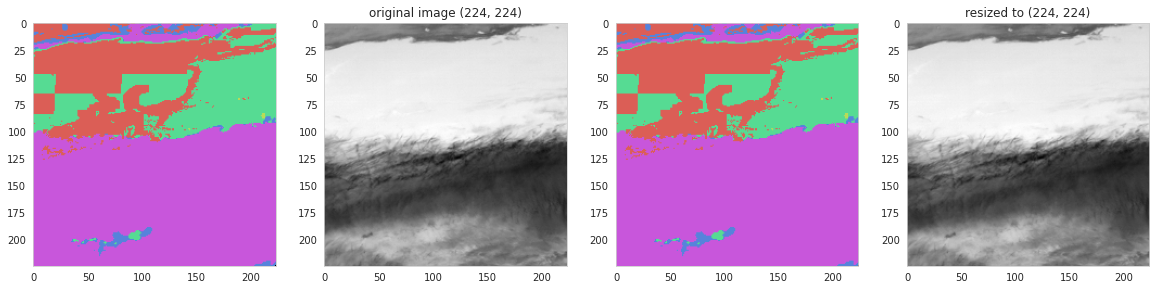

seg.shape=(224, 224, 3), img_is.shape=(224, 224, 3)


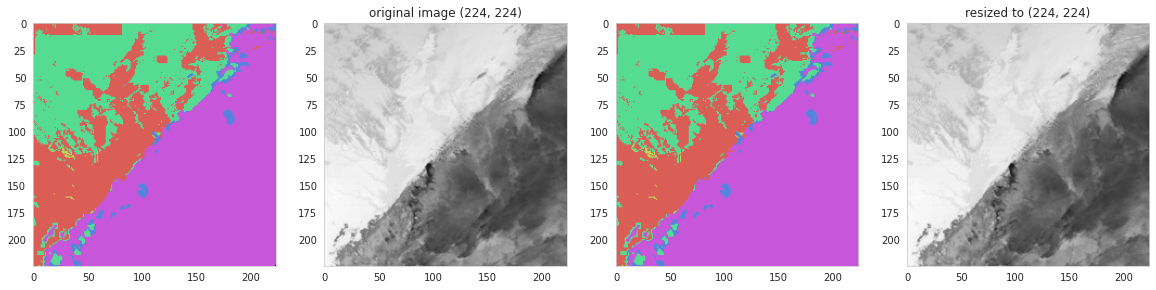

seg.shape=(224, 224, 3), img_is.shape=(224, 224, 3)


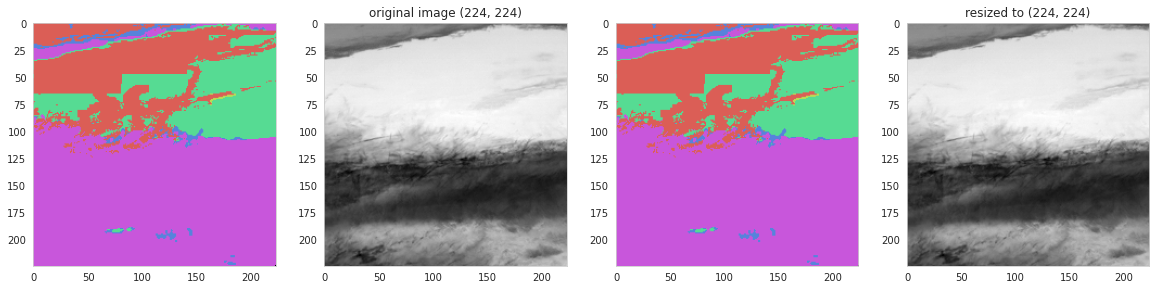

In [4]:
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224

# pickout three random files from image list
filenamelist = random.sample(sorted(glob.glob(dir_seg)), 3)

for filen in filenamelist:
    # this search string start/end are different from laptop
    # on my laptop, the value is [53:69] -- don't overwrite (rcd, 26 Feb 21) 
    searchstr = filen[60:76]
    # print(searchstr)
   
    ## read in the original image and segmentation labels
    seg = cv2.imread(filen)
    img_is = cv2.imread(dir_img+searchstr+'i.png')
    print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()


Resize all the images.  There are 450 images in this dataset.

In [5]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 255.0
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

images = sorted(glob.glob(dir_img+'*.png'))
segmentations = sorted(glob.glob(dir_seg))
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(im , input_width , input_height )  )
    Y.append( getSegmentationArr(seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

(441, 224, 224, 3) (441, 224, 224, 5)


Import Keras and Tensorflow

In [6]:
## Import key packages
import tensorflow as tf
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 
warnings.filterwarnings("ignore")

## incorporate callbacks -- Callback and EarlyStopping
from tensorflow.keras.callbacks import Callback, EarlyStopping

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
keras version 2.4.3
tensorflow version 2.4.1


VGG16 weights *.h5 file

In [7]:
## location of VGG weights
VGG_Weights_path = dir_data + "/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [8]:
def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

Split between training and testing data

In [9]:
from sklearn.utils import shuffle
train_rate = 0.8
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(352, 224, 224, 3) (352, 224, 224, 5)
(89, 224, 224, 3) (89, 224, 224, 5)


In [10]:
# Uncomment this code to get previous model results
#from tensorflow.keras.models import load_model

#get_model = "/content/drive/MyDrive/my_modelAdam"
#new_model = load_model(get_model)

#new_model.summary()
#new_model.evaluate(X_test,y_test)

Training starts here

In [11]:
from keras import optimizers
es = EarlyStopping(monitor='val_loss',patience=15)

#sgd = optimizers.SGD(lr=0.01, decay=0.0016, momentum=0.9, nesterov=True)
adam = optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

history = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,
                  epochs=500,
                  verbose=2,
                  callbacks=[es])


Epoch 1/500
11/11 - 24s - loss: 1.6147 - accuracy: 0.2319 - val_loss: 1.6017 - val_accuracy: 0.2407
Epoch 2/500
11/11 - 10s - loss: 1.5971 - accuracy: 0.2421 - val_loss: 1.5954 - val_accuracy: 0.2478
Epoch 3/500
11/11 - 10s - loss: 1.5899 - accuracy: 0.2591 - val_loss: 1.5870 - val_accuracy: 0.2551
Epoch 4/500
11/11 - 10s - loss: 1.5808 - accuracy: 0.2711 - val_loss: 1.5778 - val_accuracy: 0.2748
Epoch 5/500
11/11 - 10s - loss: 1.5749 - accuracy: 0.2813 - val_loss: 1.5773 - val_accuracy: 0.2754
Epoch 6/500
11/11 - 10s - loss: 1.5655 - accuracy: 0.2920 - val_loss: 1.5593 - val_accuracy: 0.2924
Epoch 7/500
11/11 - 10s - loss: 1.5471 - accuracy: 0.3066 - val_loss: 1.5384 - val_accuracy: 0.3077
Epoch 8/500
11/11 - 10s - loss: 1.5304 - accuracy: 0.3175 - val_loss: 1.5228 - val_accuracy: 0.3257
Epoch 9/500
11/11 - 10s - loss: 1.5036 - accuracy: 0.3365 - val_loss: 1.5029 - val_accuracy: 0.3277
Epoch 10/500
11/11 - 11s - loss: 1.4767 - accuracy: 0.3520 - val_loss: 1.4659 - val_accuracy: 0.3534

In [12]:
# Save the entire model as a SavedModel.
dir_data = "/content/drive/MyDrive/my_modelAdam"
model.save(dir_data) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_modelAdam/assets


 Plot the change in loss over epochs

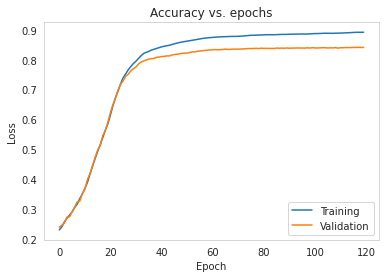

In [13]:
# Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

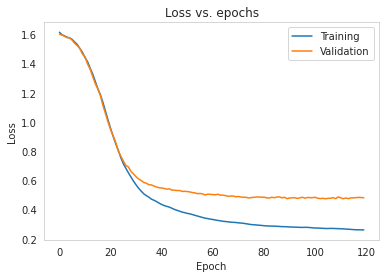

In [14]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [15]:
# Compute and display the loss and accuracy of the trained model on the test set.
test_loss, test_accuracy = model.evaluate(x=X_test, y=y_test, verbose=False)
print('accuracy: {acc:0.4f}'.format(acc=test_accuracy))
print('loss: {loss:0.4f}'.format(loss=test_loss))

accuracy: 0.8409
loss: 0.4812


### Calculate intersection over union for each segmentation class

In [16]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

(89, 224, 224) (89, 224, 224)


Visualize the model performance

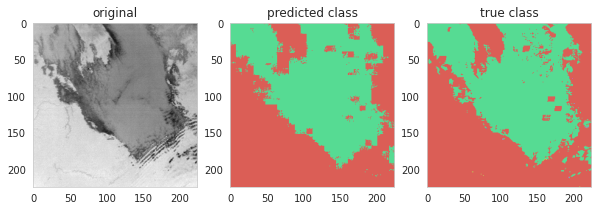

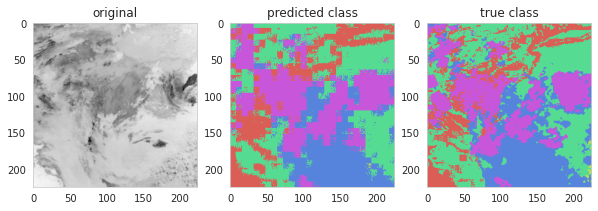

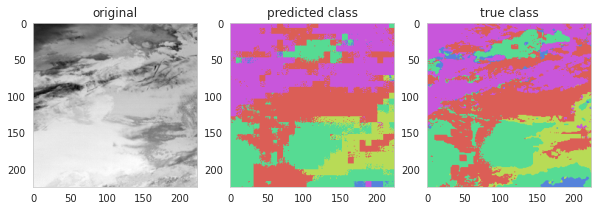

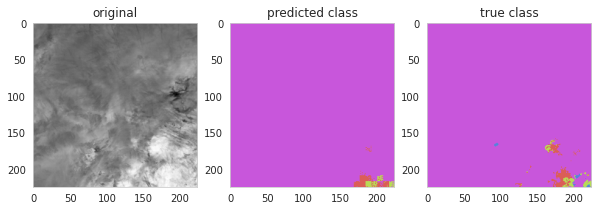

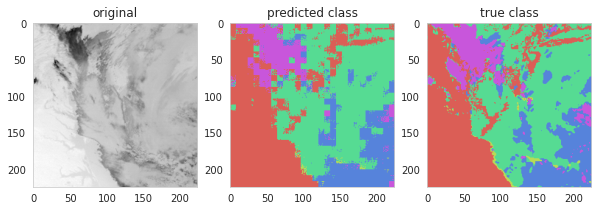

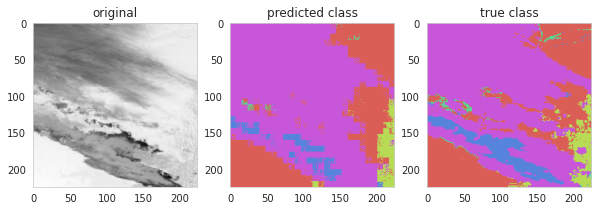

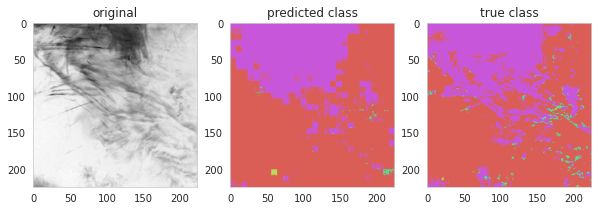

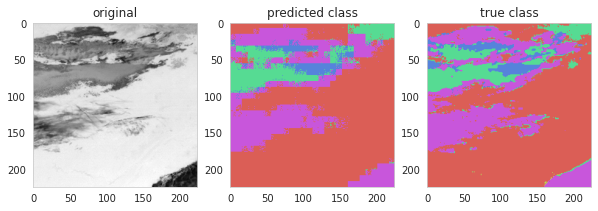

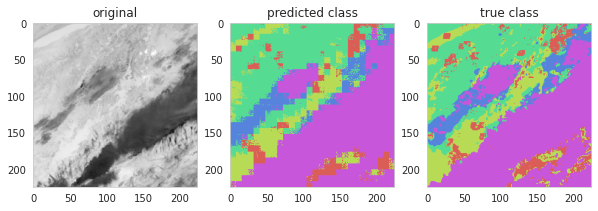

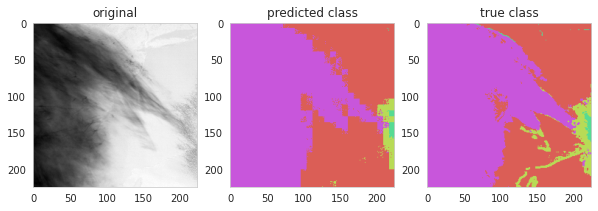

In [17]:
shape = (224,224)
n_classes= 5

for i in range(10):
    img_is  = (X_test[i])*(255.0)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()